In [29]:
# cargar las bibliotecas que usaremos

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from matplotlib.cm import get_cmap
from wrf import to_np, getvar, CoordPair, vertcross, interpline
import wrf
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.size'] = 20

In [30]:
filename = []
for j in range(1,32):
    filename.append('/ServerData/WRF_Pronostico2/2022/07_julio/wrfout_d02_2022-07-%02d_00.nc'%(j))
filename2 = []
for j in range(1,32):
    filename2.append('/ServerData/WRF_Pronostico2/2022/12_diciembre/wrfout_d02_2022-12-%02d_00.nc'%(j))

wrfout_d02_2022-01-11_00.nc
wrfout_d02_2022-01-12_00.nc


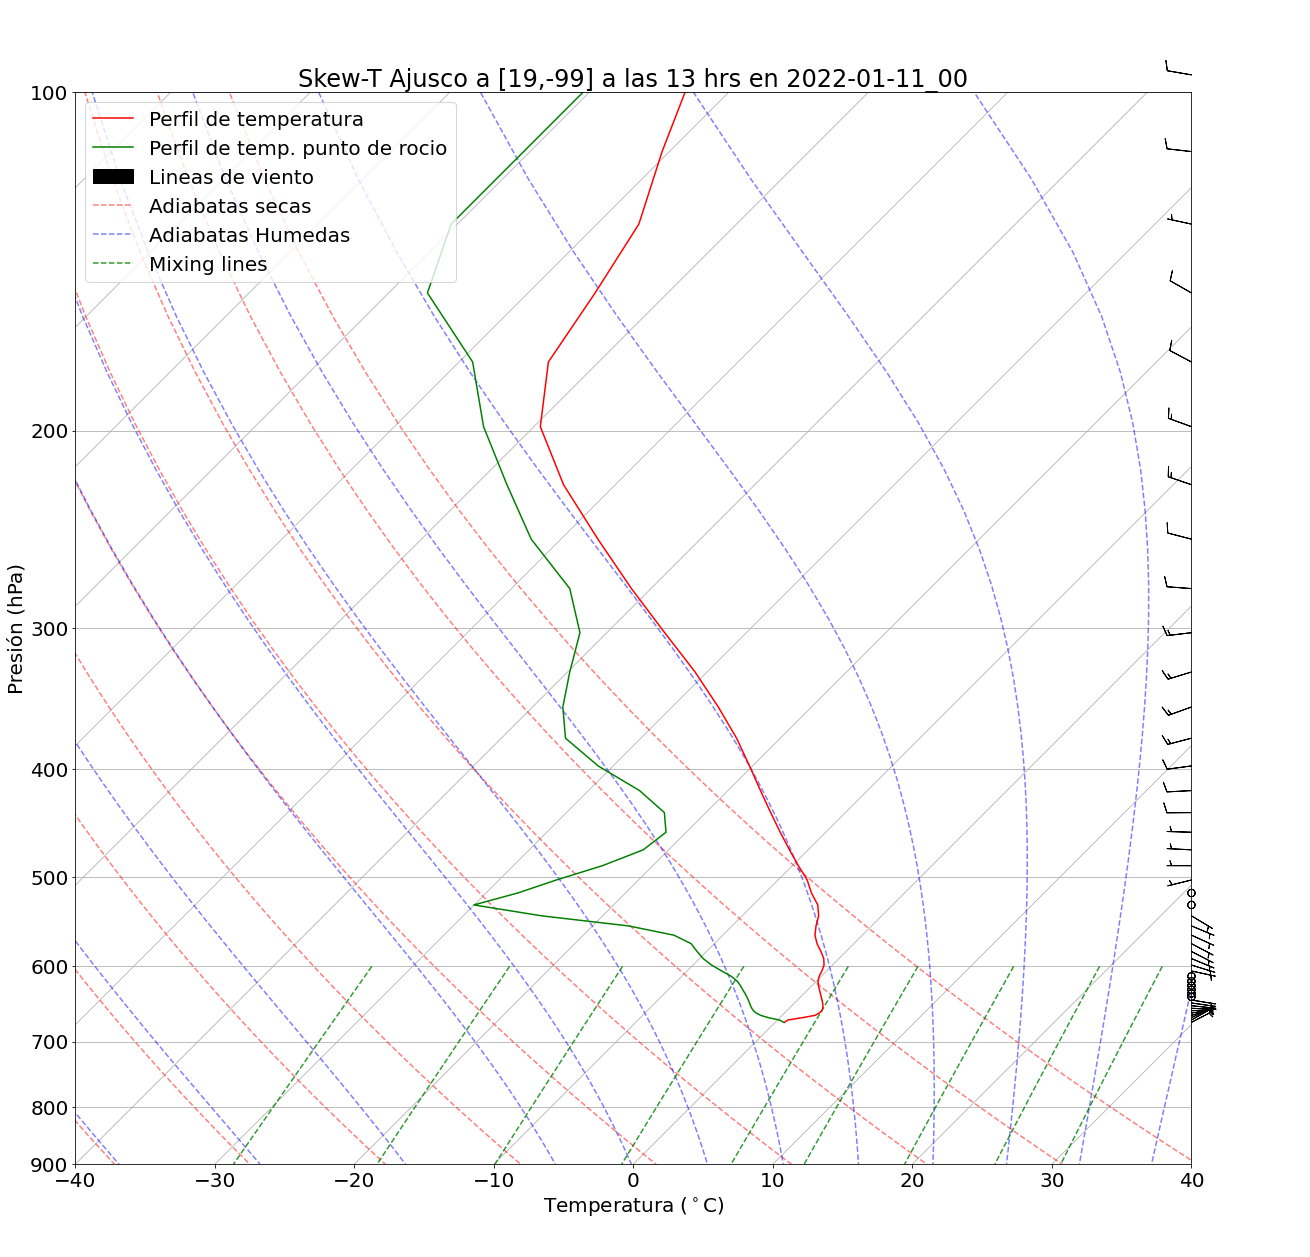

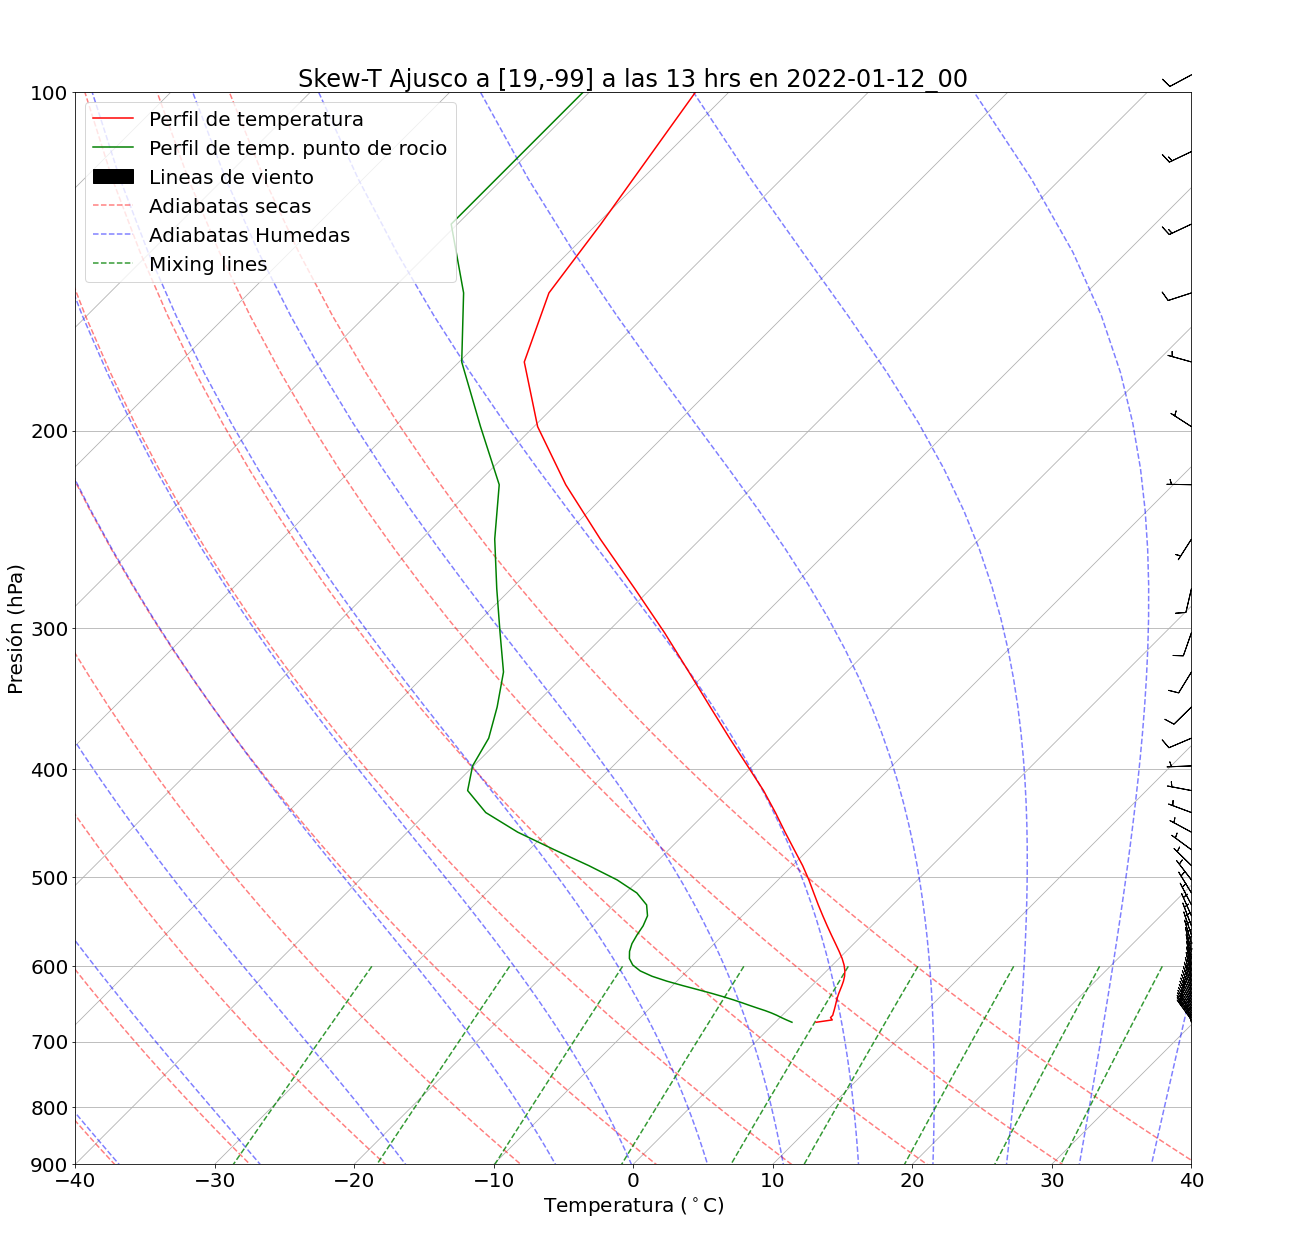

In [60]:

for nombre in filename:

    ncfile=Dataset(nombre)
    # cargar DataFrame con xarray
    ds = xr.open_dataset(nombre)
    print(nombre)
    #Coordenadas a utilizar dónde solo cambiaremos las latitudes
    lat= 19.201
    lon = -99.334808

    k=13
    t_cdmx=k-6

    #Este comando cambia nuestras coordenas de lat y long a los indices más cercanos al valor deseado
    x_y = wrf.ll_to_xy(ncfile, lat, lon)

    #PRESIÓN
    p1=wrf.getvar(ncfile,"pressure",timeidx=k)
    #Aquí se toman los calores para todos niveles de altitud pero solo para la coordenada deseada.
    #NOTA: 
    #Por alguna razón wrf.ll_to_xy invierte los indices (de lat, lon a lon, lat), es por eso que tomamos
    #el indice 1 para latitud y 0 para longitud
    p = p1[:,x_y[1],x_y[0]]

    #TEMPERATURA EN CELSIUS
    tc1=wrf.getvar(ncfile,"tc",timeidx=k,meta=False)
    tc = tc1[:,x_y[1],x_y[0]]


    #TEMPERATURA PUNTO DE ROCIO
    td1=wrf.getvar(ncfile,"td",timeidx=k,meta=False)
    td = td1[:,x_y[1],x_y[0]]


    #COMPONENTE U DE LA VELOCIDAD
    ua1=wrf.getvar(ncfile,"ua",timeidx=k,meta=False)
    ua = ua1[:,x_y[1],x_y[0]]


    #COMPONENTE V DE LA VELOCIDAD
    va1=wrf.getvar(ncfile,"va",timeidx=k,meta=False)
    va = va1[:,x_y[1],x_y[0]]

    fig = plt.figure(figsize=(20,20 ))
    skew = SkewT(fig, rotation=45)
    #Perfil de temperatura
    P_t = skew.plot(p, tc, 'r')
    #perfil de temperatura del punto de rocio
    P_procio = skew.plot(p, td, 'g')
    #rapidez y dirección del viento
    wb=skew.plot_barbs(p, ua, va)

    #Graficamos la lineas de adiabatas secas
    da=skew.plot_dry_adiabats()
    #adiabatas humedas
    ma=skew.plot_moist_adiabats()

    #mixig lines 
    ml=skew.plot_mixing_lines()

    skew.ax.legend([P_t,P_procio,wb,da,ma,ml],
                  labels=['Perfil de temperatura','Perfil de temp. punto de rocio','Lineas de viento',
                               'Adiabatas secas','Adiabatas Humedas','Mixing lines'], loc='upper left' )
    if t_cdmx < 0:
            t_cdmx = t_cdmx+24
    skew.ax.set_title('Skew-T Ajusco a [%d,%d] a las %d hrs en %s'%(lat, lon,k, nombre[-16:-3]))
    #Rango de temperaturas
    skew.ax.set_xlim(-40, 40)
    skew.ax.set_ylim(900,100)
    skew.ax.set_xlabel('Temperatura ($^\circ$C)')
    skew.ax.set_ylabel('Presión (hPa)')

    #Comando opciónal en caso de querer guardar las gráficas
    plt.savefig('SkewT_aju_%s.png'%nombre[-16:-3])


Aquí los campos de velocidades, recuerda checar coordenadas y dimensiones

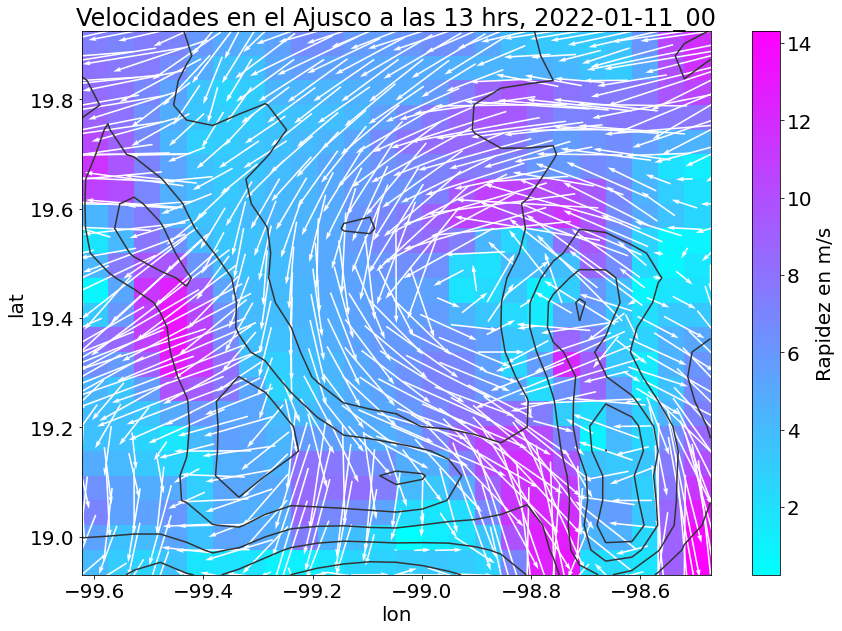

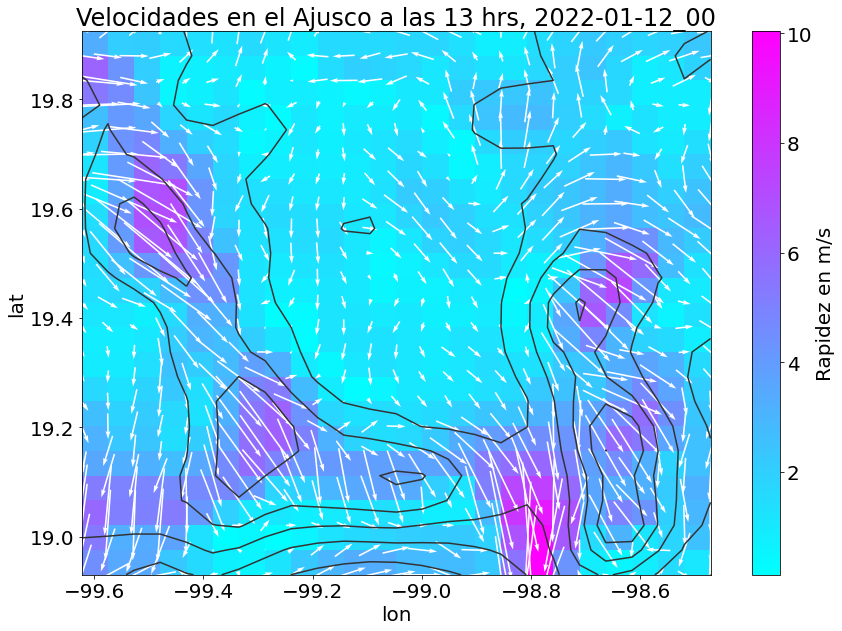

In [61]:
def unstagger(ugrid, vgrid):
    """ Interpolate u and v component values to values at grid cell centres (from D.Latornell for NEMO output).
    The shapes of the returned arrays are 1 less than those of
    the input arrays in the y and x dimensions.
    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`
    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`
    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    return u, v#Tiempo
t = 13

#altura
k=3
for nombre in filename:
    ncfile=Dataset(nombre)
    # cargar DataFrame con xarray
    ds = xr.open_dataset(nombre)
    #Velocidad meridional y zonal
    u0 = ds.U[t,k,:,:]#tiempo, altura
    v0 = ds.V[t,k,:,:]
    U0,V0 = unstagger(u0,v0)
    #Limites
    #Coordenadas del valle de méxico
    lat1 = 18.92992
    lat2 = 19.969967
    lon1 = -99.62255
    lon2 = -98.42362

    x_y_1 = wrf.ll_to_xy(ncfile, lat1, lon1).data
    x_y_2 = wrf.ll_to_xy(ncfile, lat2, lon2).data

    ilat_1 = x_y_1[1]#95'''Esto es para las coordenadas de arriba, si se modifican'''
    ilat_2 = x_y_2[1]#119'''entonces ya no son estos indices'''
    ilon_1 = x_y_1[0]#136
    ilon_2 = x_y_2[0]#162

    Long=ds.XLONG[k,x_y_1[1]:x_y_2[1],x_y_1[0]:x_y_2[0]]
    Lat=ds.XLAT[k,x_y_1[1]:x_y_2[1],x_y_1[0]:x_y_2[0]]

    fig, ax = plt.subplots(1,1, figsize=(15,10))
    spd = np.sqrt(U0[ilat_1:ilat_2,ilon_1:ilon_2].data**2+V0[ilat_1:ilat_2,ilon_1:ilon_2].data**2)
    pc = ax.pcolormesh(Long,Lat,spd[:,:],cmap = 'cool' )# Si se le agrega un _r al cmap lo pone en reversa
    plt.colorbar(pc, label='Rapidez en m/s')
    cn = ax.contour(Long,Lat,ds.HGT[t,ilat_1:ilat_2,ilon_1:ilon_2], colors='0.2')

    ax.quiver(Long,Lat,U0[ilat_1:ilat_2,ilon_1:ilon_2],V0[ilat_1:ilat_2,ilon_1:ilon_2],scale=45,color='w',pivot='mid')
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    ax.set_title('Velocidades en el Ajusco a las %d hrs, %s'%(t,nombre[-16:-3]))
    ax.set_aspect(1)
    plt.savefig('Vel_aju_%s.png'%nombre[-16:-3])

wrfout_d02_2022-01-11_00.nc
wrfout_d02_2022-01-12_00.nc


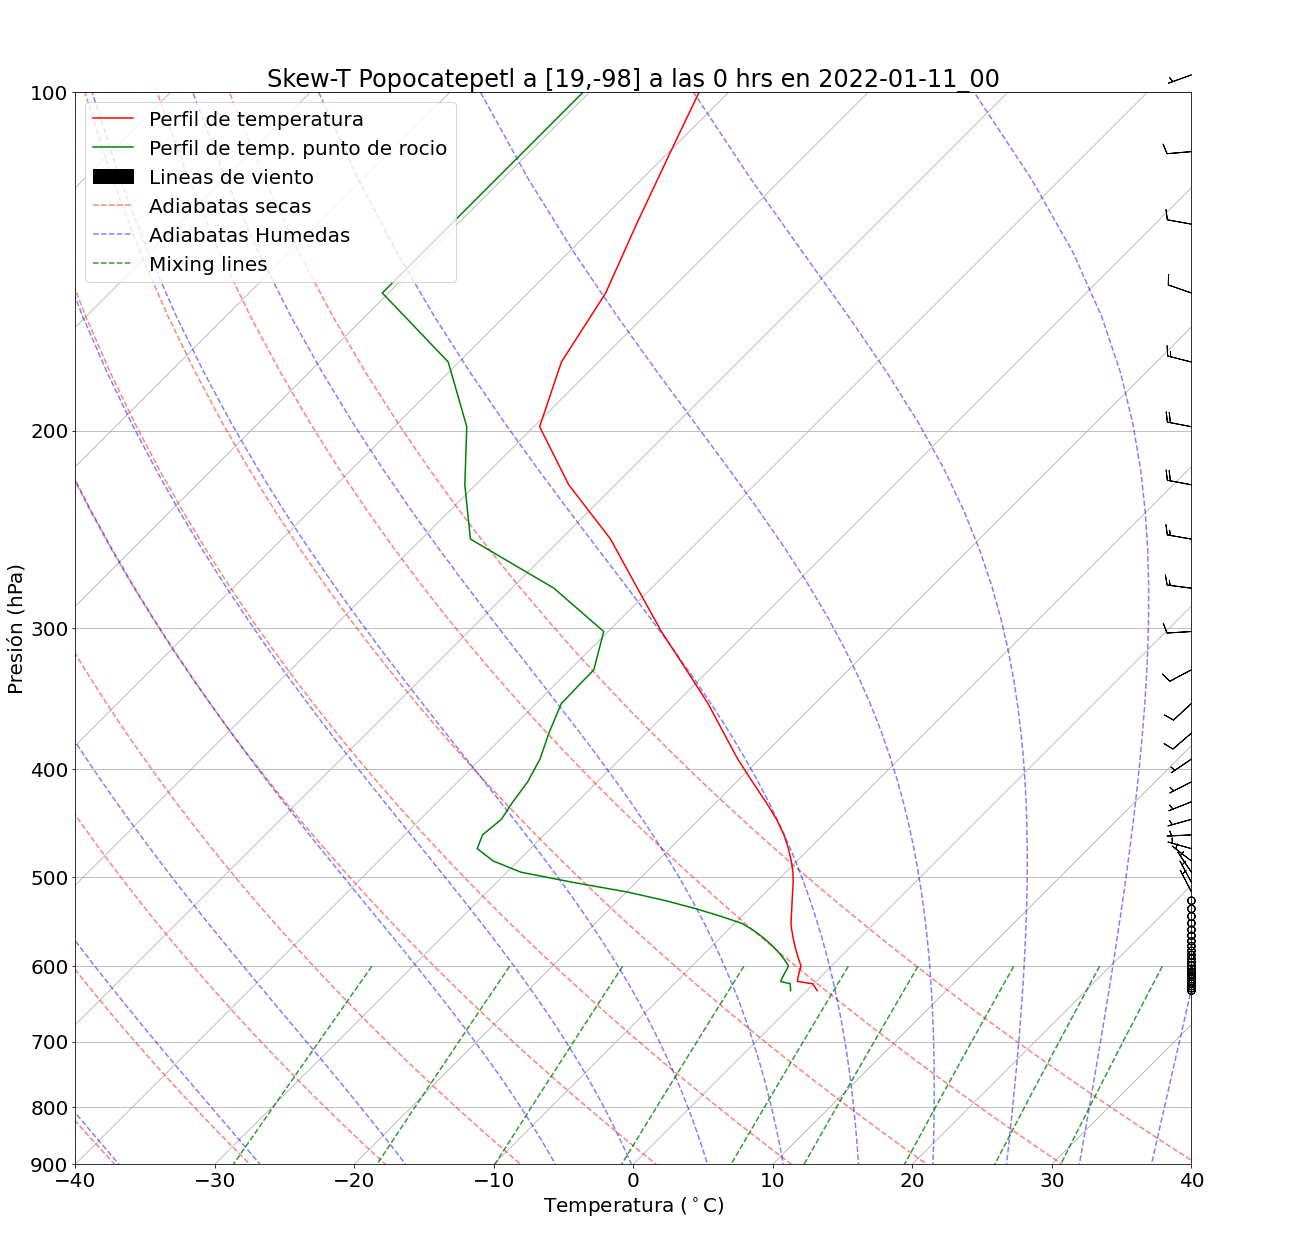

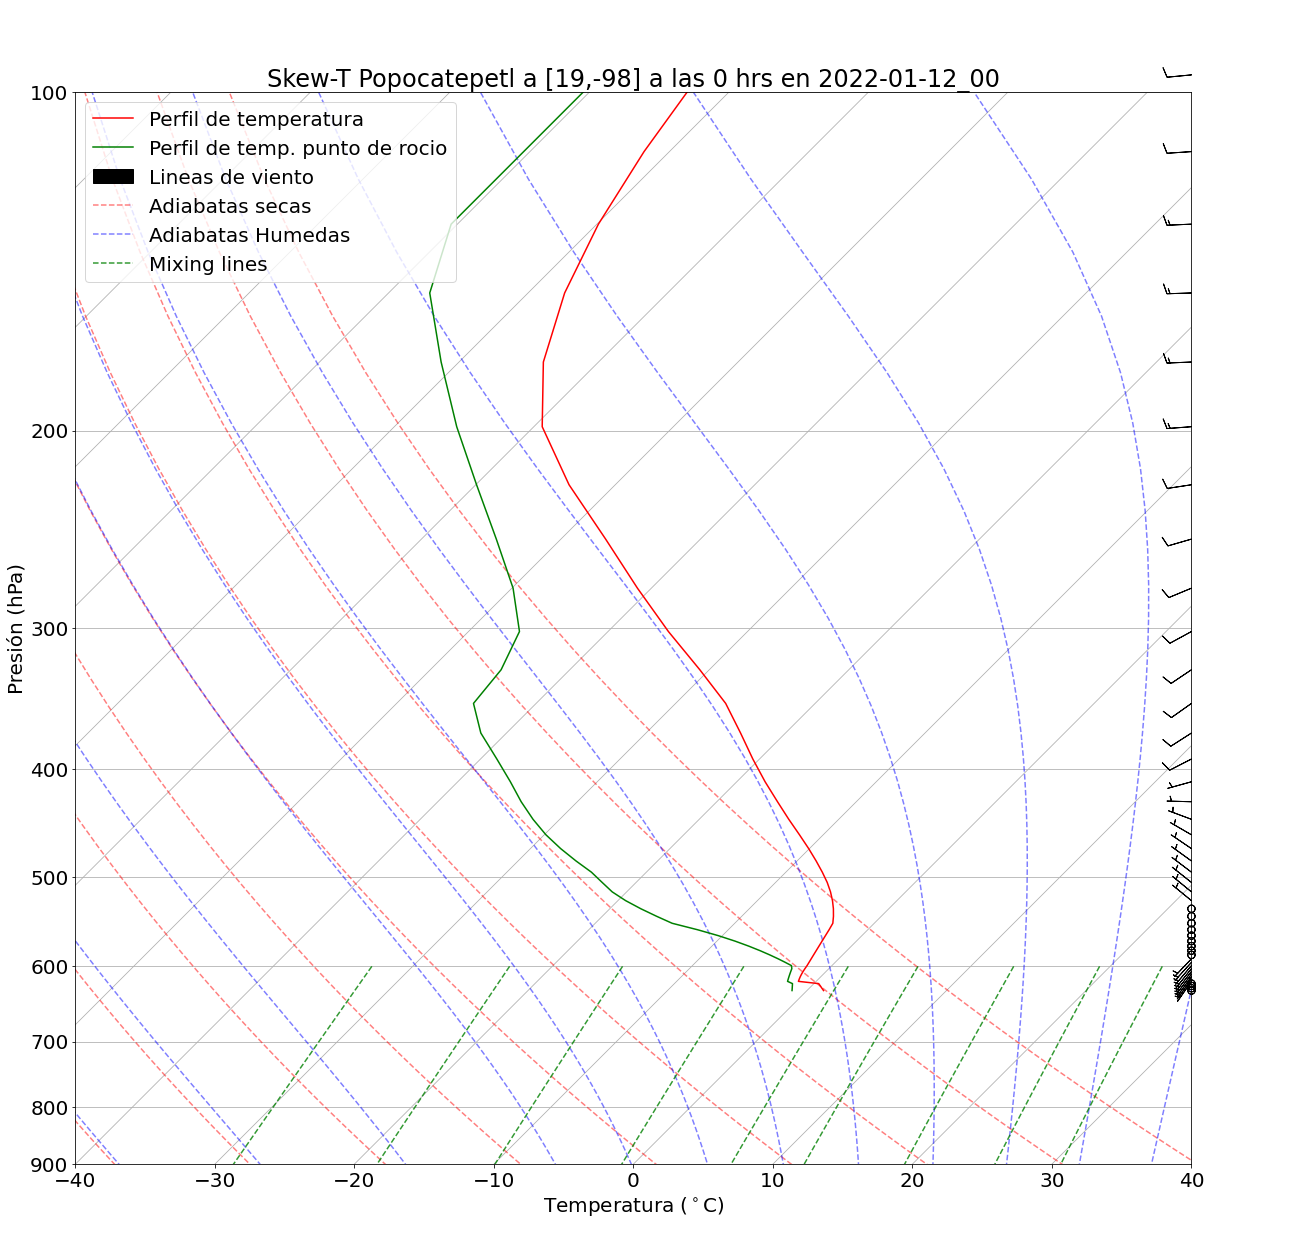

In [63]:
for nombre in filename2:

    ncfile=Dataset(nombre)
    # cargar DataFrame con xarray
    ds = xr.open_dataset(nombre)
    
    #Coordenadas a utilizar dónde solo cambiaremos las latitudes
    lat= 19.1565
    lon = -98.663414

    k=0 #tiempo

    #Este comando cambia nuestras coordenas de lat y long a los indices más cercanos al valor deseado
    x_y = wrf.ll_to_xy(ncfile, lat, lon)

    #PRESIÓN
    p1=wrf.getvar(ncfile,"pressure",timeidx=k)
    #Aquí se toman los calores para todos niveles de altitud pero solo para la coordenada deseada.
    #NOTA: 
    #Por alguna razón wrf.ll_to_xy invierte los indices (de lat, lon a lon, lat), es por eso que tomamos
    #el indice 1 para latitud y 0 para longitud
    p = p1[:,x_y[1],x_y[0]]

    #TEMPERATURA EN CELSIUS
    tc1=wrf.getvar(ncfile,"tc",timeidx=k,meta=False)
    tc = tc1[:,x_y[1],x_y[0]]


    #TEMPERATURA PUNTO DE ROCIO
    td1=wrf.getvar(ncfile,"td",timeidx=k,meta=False)
    td = td1[:,x_y[1],x_y[0]]


    #COMPONENTE U DE LA VELOCIDAD
    ua1=wrf.getvar(ncfile,"ua",timeidx=k,meta=False)
    ua = ua1[:,x_y[1],x_y[0]]


    #COMPONENTE V DE LA VELOCIDAD
    va1=wrf.getvar(ncfile,"va",timeidx=k,meta=False)
    va = va1[:,x_y[1],x_y[0]]

    fig = plt.figure(figsize=(20,20 ))
    skew = SkewT(fig, rotation=45)
    #Perfil de temperatura
    P_t = skew.plot(p, tc, 'r')
    #perfil de temperatura del punto de rocio
    P_procio = skew.plot(p, td, 'g')
    #rapidez y dirección del viento
    wb=skew.plot_barbs(p, ua, va)

    #Graficamos la lineas de adiabatas secas
    da=skew.plot_dry_adiabats()
    #adiabatas humedas
    ma=skew.plot_moist_adiabats()

    #mixig lines 
    ml=skew.plot_mixing_lines()

    skew.ax.legend([P_t,P_procio,wb,da,ma,ml],
                  labels=['Perfil de temperatura','Perfil de temp. punto de rocio','Lineas de viento',
                               'Adiabatas secas','Adiabatas Humedas','Mixing lines'], loc='upper left' )
    if t_cdmx < 0:
            t_cdmx = t_cdmx+24
    skew.ax.set_title('Skew-T Popocatepetl a [%d,%d] a las %d hrs en %s'%(lat, lon,k, nombre[-16:-3]))
    #Rango de temperaturas
    skew.ax.set_xlim(-40, 40)
    skew.ax.set_ylim(900,100)
    skew.ax.set_xlabel('Temperatura ($^\circ$C)')
    skew.ax.set_ylabel('Presión (hPa)')

    #Comando opciónal en caso de querer guardar las gráficas
    plt.savefig('SkewT_popo_%s.png'%nombre[-16:-3])

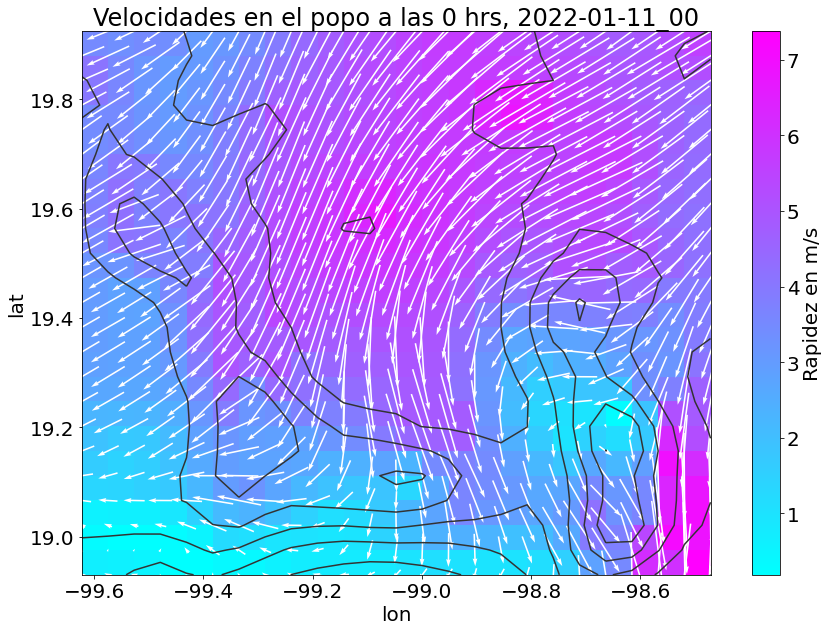

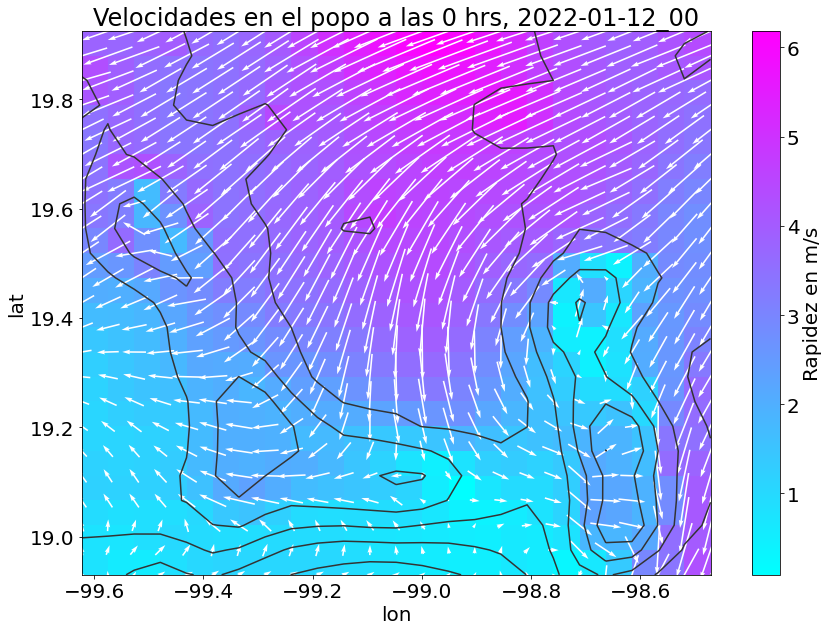

In [64]:

t = 0
#altura
k=0
for nombre in filename2:
    ncfile=Dataset(nombre)
    # cargar DataFrame con xarray
    ds = xr.open_dataset(nombre)
    #Velocidad meridional y zonal
    u0 = ds.U[t,k,:,:]#tiempo, altura
    v0 = ds.V[t,k,:,:]
    U0,V0 = unstagger(u0,v0)
    #Limites
    #Coordenadas del valle de méxico
    lat1 = 18.92992
    lat2 = 19.969967
    lon1 = -99.62255
    lon2 = -98.42362

    x_y_1 = wrf.ll_to_xy(ncfile, lat1, lon1).data
    x_y_2 = wrf.ll_to_xy(ncfile, lat2, lon2).data

    ilat_1 = x_y_1[1]#95'''Esto es para las coordenadas de arriba, si se modifican'''
    ilat_2 = x_y_2[1]#119'''entonces ya no son estos indices'''
    ilon_1 = x_y_1[0]#136
    ilon_2 = x_y_2[0]#162

    Long=ds.XLONG[k,x_y_1[1]:x_y_2[1],x_y_1[0]:x_y_2[0]]
    Lat=ds.XLAT[k,x_y_1[1]:x_y_2[1],x_y_1[0]:x_y_2[0]]

    fig, ax = plt.subplots(1,1, figsize=(15,10))
    spd = np.sqrt(U0[ilat_1:ilat_2,ilon_1:ilon_2].data**2+V0[ilat_1:ilat_2,ilon_1:ilon_2].data**2)
    pc = ax.pcolormesh(Long,Lat,spd[:,:],cmap = 'cool' )# Si se le agrega un _r al cmap lo pone en reversa
    plt.colorbar(pc, label='Rapidez en m/s')
    cn = ax.contour(Long,Lat,ds.HGT[t,ilat_1:ilat_2,ilon_1:ilon_2], colors='0.2')

    ax.quiver(Long,Lat,U0[ilat_1:ilat_2,ilon_1:ilon_2],V0[ilat_1:ilat_2,ilon_1:ilon_2],scale=45,color='w',pivot='mid')
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    ax.set_title('Velocidades en el popo a las %d hrs, %s'%(t,nombre[11:-3]))
    ax.set_aspect(1)
    print(nombre)
    plt.savefig('Vel_popo_%s.png'%nombre[-16:-3])